<a href="https://colab.research.google.com/github/KevinDHuynh/LastMile/blob/master/Transportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commuter Rail Bus System - "Last-Mile" Problem

In [0]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gp
import shapely
from google.colab import files
uploaded = files.upload()

Uses MA Local Access Score dataset from http://localaccess.mapc.org
Geopandas is used to import geospacial data into a dataframe to be used.

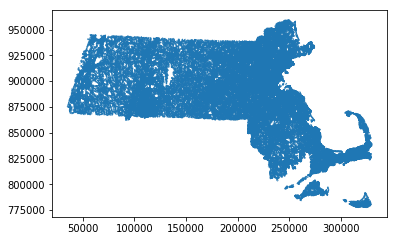

In [0]:
las = gp.read_file('Local_Access_Scores.gdb.zip')
las.plot()

Dataset is a collection of all (sub)streets in Massachusetts and their local Access Scores, based upon both walking and biking trips to schools, shops, parts, and transit.

In [0]:
list(las.columns)

['rd_inv_id',
 'class',
 'admin_type',
 'rt_number',
 'altrtnum1',
 'streetname',
 'functional',
 'truckroute',
 'sidewalk',
 'speedlimit',
 'adt',
 'adt_year',
 'wlk_rw',
 'wlk_sch_rw',
 'wlk_shp_rw',
 'wlk_prk_rw',
 'wlk_trn_rw',
 'wlk',
 'wlk_sch',
 'wlk_shp',
 'wlk_prk',
 'wlk_trn',
 'bik_rw',
 'bik_sch_rw',
 'bik_shp_rw',
 'bik_prk_rw',
 'bik_trn_rw',
 'bik',
 'bik_sch',
 'bik_shp',
 'bik_prk',
 'bik_trn',
 'cmputil_rw',
 'cmputil',
 'muni_id',
 'municipal',
 'Shape_Length',
 'geometry']

Field names are listed and described in the User Guide for the dataset.
Table 1 is used. Shape_Length and geometry are created from GeoPandas' import
http://localaccess.mapc.org/assets/pdfs/LocalAccess_User_Guide.pdf 

Cut down dataset to only use major roads (Class = 4) 

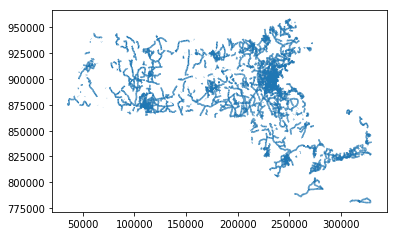

In [0]:
las_clean =  las[las['class']== 4.0]

las_clean.plot()
#las_clean.head(5)


The municpal field can then further cut down this data to a specific city. Waltham is used for this example.

,rd_inv_id,class,admin_type,rt_number,altrtnum1,streetname,functional,truckroute,sidewalk,speedlimit,...,bik_sch,bik_shp,bik_prk,bik_trn,cmputil_rw,cmputil,muni_id,municipal,Shape_Length,geometry
40464,39185600.0,4.0,0.0,,,TRAPELO ROAD,5.0,0.0,0,0.0,...,0.0,0.040904,4.761905,0.0,19.511628,1.478449,308.0,Waltham,2.452113,(LINESTRING (218980.7402999997 907836.98059999...
135861,39397000.0,4.0,0.0,,,WESTON STREET,3.0,0.0,0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,308.0,Waltham,145.536329,(LINESTRING (218847.436999999 902235.499899998...
135891,39185600.0,4.0,0.0,,,TRAPELO ROAD,5.0,0.0,0,0.0,...,0.0,0.031814,14.285715,0.0,98.716238,7.480000,308.0,Waltham,72.751277,(LINESTRING (218982.7832999974 907835.62449999...
135903,39185500.0,4.0,0.0,,,TRAPELO ROAD,5.0,0.0,0,0.0,...,0.0,0.031814,14.285715,0.0,98.716238,7.480000,308.0,Waltham,88.682454,(LINESTRING (219042.5821999982 907794.19790000...
135915,39402600.0,4.0,0.0,,,WESTON STREET,3.0,0.0,0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,308.0,Waltham,179.311915,(LINESTRING (219074.6559000015 902467.00019999...


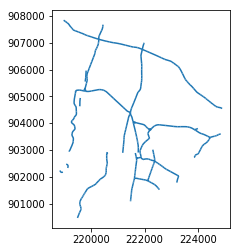

In [0]:
waltham = las_clean[las_clean['municipal']=='Waltham']
#leominster = df[df['municipal']=='Leominster']
#fitchburg = df[df['municipal']=='Fitchburg']
#acton = df[df['municipal']=='Acton']
waltham.plot()
waltham.head()

Then in order to filter the data to just one subsection per street we sort all values by their "Local Access" Score and keep the subsections with the highest value

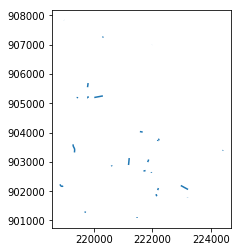

In [0]:
waltham = waltham.sort_values(by=['cmputil'])
waltham = waltham.drop_duplicates('streetname')
waltham.plot()

This cuts us down to 25 total values to examine for the bus route

In [0]:
waltham.head(25)

,rd_inv_id,class,admin_type,rt_number,altrtnum1,streetname,functional,truckroute,sidewalk,speedlimit,...,bik_sch,bik_shp,bik_prk,bik_trn,cmputil_rw,cmputil,muni_id,municipal,Shape_Length,geometry
154403,39171100.0,4.0,0.0,,,LEXINGTON STREET,3.0,0.0,1,30.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,308.0,Waltham,1.597442,(LINESTRING (221983.3630999997 906995.95540000...
135861,39397000.0,4.0,0.0,,,WESTON STREET,3.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,308.0,Waltham,145.536329,(LINESTRING (218847.436999999 902235.499899998...
137584,39166700.0,4.0,0.0,,,MOODY STREET,3.0,0.0,2,30.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,308.0,Waltham,28.247967,(LINESTRING (221474.2877999991 901087.69370000...
136372,39093500.0,4.0,0.0,,,INTERSTATE 95 NB CD ROAD,5.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,308.0,Waltham,142.852643,(LINESTRING (219784.7646000013 905550.57090000...
138077,39297400.0,4.0,0.0,,,BEAVER STREET ROTARY,5.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,308.0,Waltham,51.219847,(LINESTRING (222196.8703000024 903778.59519999...
138023,39400900.0,4.0,0.0,,,HIGH STREET,5.0,0.0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,308.0,Waltham,76.360189,(LINESTRING (222133.3122000024 901900.75019999...
137920,39400300.0,4.0,0.0,,,ELM STREET,5.0,0.0,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.163791,0.012411,308.0,Waltham,25.968020,"(LINESTRING (221960.2653999999 902651.25, 2219..."
137658,39398900.0,4.0,0.0,,,BEAVER STREET,5.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.205564,0.015576,308.0,Waltham,96.695913,(LINESTRING (221572.0623999983 904035.68780000...
136126,39396800.0,4.0,0.0,,,SECOND AVENUE,5.0,0.0,1,0.0,...,0.119454,0.022724,0.000000,0.000000,1.461597,0.110749,308.0,Waltham,44.459297,"(LINESTRING (219431.3278999999 905174.875, 219..."
136380,39396700.0,4.0,0.0,,,WYMAN STREET,5.0,2.0,0,0.0,...,0.000000,0.277235,0.000000,0.000000,1.600126,0.121246,308.0,Waltham,53.652573,(LINESTRING (219792.6560999975 905240.37519999...


In [0]:
waltham.streetname

154403            LEXINGTON STREET
135861               WESTON STREET
137584                MOODY STREET
136372    INTERSTATE 95 NB CD ROAD
138077        BEAVER STREET ROTARY
138023                 HIGH STREET
137920                  ELM STREET
137658               BEAVER STREET
136126               SECOND AVENUE
136380                WYMAN STREET
136022              BEAR HILL ROAD
136311                SOUTH STREET
136860                 MAIN STREET
136366               WINTER STREET
139032               WARREN STREET
137737               CARTER STREET
40464                 TRAPELO ROAD
136661                SMITH STREET
136502            TOTTEN POND ROAD
138630              FARWELL STREET
138054                LYMAN STREET
138524                RIVER STREET
137373                BACON STREET
137833               CHURCH STREET
138060               NEWTON STREET
Name: streetname, dtype: object

From here the time/knowledge restrictions started to become more evident so we manually decided the route. 

Using a manually-created dataset to determine where the stop is, we create a route that starts and ends on the street of the Commuter Rail stop.

Then on Google Maps we plug in the first 10 destinations and order them in a logical order (a circle-like route).

Remove any "outlier" streets (ones too hard to get to) and replace with the next street in the dataset.


In [0]:
manually-created database POC
#fitchburg = pd.read_csv('Fitchburg-Line-Dataset.csv')

SyntaxError: ignored

In [0]:
from IPython.core.display import HTML
HTML('<iframe src="https://www.google.com/maps/embed?pb=!1m76!1m12!1m3!1d47147.551143328434!2d-71.26886418096029!3d42.39106948696591!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!4m61!3e0!4m5!1s0x89e382d717cb2c2f%3A0x2609706b46f6fa46!2sCarter+St%2C+Waltham%2C+MA+02453!3m2!1d42.3745739!2d-71.2356258!4m5!1s0x89e382df30f21049%3A0x456862125a0cf169!2sMoody+St%2C+Waltham%2C+Massachusetts!3m2!1d42.3681104!2d-71.2374404!4m5!1s0x89e3833bd5155edb%3A0xaf2acf612d9761d5!2sWeston+St%2C+Waltham%2C+MA+02453!3m2!1d42.374151!2d-71.2577024!4m5!1s0x89e3834993c0620f%3A0x3558f4cb457c3fc6!2sBear+Hill+Rd%2C+Waltham%2C+MA+02451!3m2!1d42.381990599999995!2d-71.2656109!4m5!1s0x89e39cb5d86314a7%3A0xf77a2c5dcb37813a!2s2nd+Ave%2C+Waltham%2C+MA+02451!3m2!1d42.392683!2d-71.264613!4m5!1s0x89e39cc2200f042b%3A0x5e83a27a955f0621!2sWyman+St%2C+Waltham%2C+MA+02451!3m2!1d42.4043759!2d-71.2580126!4m5!1s0x89e39d1f81ebb33b%3A0x5550684488a79d12!2sTrapelo+Rd%2C+Waltham%2C+MA!3m2!1d42.4104317!2d-71.2321023!4m5!1s0x89e39d26fa03bb25%3A0x85622ea8aae7b32a!2sLexington+St%2C+Waltham%2C+MA!3m2!1d42.3946657!2d-71.2368401!4m5!1s0x89e39d343d98de29%3A0x98162450dd5468f3!2sBeaver+St%2C+Waltham%2C+MA!3m2!1d42.3851405!2d-71.220371!4m5!1s0x89e39d530daceb3b%3A0xabda08cc4d036218!2sWarren+Street%2C+Waltham%2C+MA!3m2!1d42.377686999999995!2d-71.2004412!5e0!3m2!1sen!2sus!4v1555240630806!5m2!1sen!2sus" width="600" height="450" frameborder="0" style="border:0" allowfullscreen></iframe>')

In [0]:
!setup.py install

In [0]:
!pip install geopandas